In [ ]:
import numpy as np
from keras.datasets import mnist

In [ ]:
# 이미지 내부 값, 구조 ppt 추가, 컬러/흑백 이미지 구조 설명 추가
# subplot 사용법, 기초 이미지 데이터 다루는 방법

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [ ]:
import matplotlib.pyplot as plt

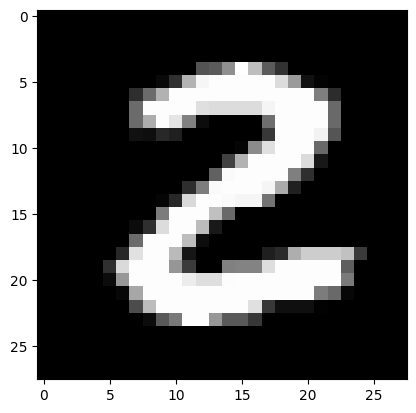

In [ ]:
plt.imshow(x_train[25], 'gray')
plt.show()

In [ ]:
x_train[25].shape

(28, 28)

In [ ]:
y_train[25]

2

In [ ]:
reshape = 784
x_train = x_train.reshape(60000, reshape)
x_test = x_test.reshape(10000, reshape)
x_train = x_train.astype('float64') / 255
x_test = x_test.astype('float64') / 255

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [ ]:
# encoding = np.eye(10)[y_train]
# print(encoding[0:3])

In [ ]:
y_train_ecd = np.eye(10)[y_train]
y_test_ecd = np.eye(10)[y_test]

In [ ]:
print(x_train.shape, x_test.shape, '/', y_train_ecd.shape, y_test_ecd.shape)
# print(x_train.shape, x_test.shape, '/', y_train.shape, y_test.shape)

(60000, 784) (10000, 784) / (60000, 10) (10000, 10)


In [ ]:
batch_size = 100

x_train = x_train.reshape(-1, batch_size, 784)
x_test = x_test.reshape(-1, batch_size, 784)
y_train_ecd = y_train_ecd.reshape(600, -1, 10)
y_test_ecd = y_test_ecd.reshape(100, -1, 10)
# y_train = y_train.reshape(-1, batch_size, 1)
# y_test = y_test.reshape(-1, batch_size, 1)

print(x_train.shape, x_test.shape, '/', y_train_ecd.shape, y_test_ecd.shape)
# print(x_train.shape, x_test.shape, '/', y_train.shape, y_test.shape)

(600, 100, 784) (100, 100, 784) / (600, 100, 10) (100, 100, 10)


In [ ]:
import torch

In [ ]:
x_trainT = torch.Tensor(x_train)
x_testT = torch.Tensor(x_test)
y_trainT = torch.Tensor(y_train_ecd)
y_testT = torch.Tensor(y_test_ecd)
# y_trainT = torch.Tensor(y_train)
# y_testT = torch.Tensor(y_test)

print(type(x_train), type(x_trainT))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


In [ ]:
# 네트워크 구조 ppt에서 보여주면 좋을듯
# cross_entropy, one hot encoding

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# 모델 만들고 학습까지 시켜보기

In [ ]:
import torch.nn.functional as F

In [ ]:
class FCN(nn.Module):

  def __init__(self, in_sz, out_sz, layers=[120, 84]):
    super().__init__()
    self.fc1 = nn.Linear(in_sz, layers[0])
    self.fc2 = nn.Linear(layers[0], layers[1])
    self.fc3 = nn.Linear(layers[1], out_sz)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = FCN(784, 10)
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
epochs = 1
for i in range(epochs):
  tst_corr = 0
  model.train()
  for b in range(len(x_trainT)):
    data = x_trainT[b].to(device)
    truth_ = y_trainT[b].to(device)
    y_pred = model(data)

    loss = criterion(y_pred, truth_)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # --

  with torch.no_grad():
    model.eval()
    for b in range(len(x_testT)):
      data = x_testT[b].to(device)
      truth = y_testT[b].to(device)
      y_val = model(data)

      t1 = torch.argmax(y_val, dim=1)
      t2 = torch.argmax(truth, dim=1)
      tst_corr += (t1 == t2).sum() / len(y_val) * 1.0

      # print(torch.round(truth), torch.round(y_val))
      # tst_corr += torch.sum(torch.round(truth) == torch.round(y_val)) / len(y_val) * 1.0

    loss = criterion(y_val, truth)
    print('test loss : ', loss.item())
    print('test acc : ', tst_corr.item() * 100 / len(x_testT), '%')



test loss :  0.2972002923488617
test acc :  93.74002838134766 %


In [ ]:
with torch.no_grad():
  # random_sample = np.random.randint(x_test.shape[0])
  # y_pred = model(torch.Tensor(x_test[random_sample]))
  model.eval()
  y_pred = model(torch.Tensor(x_test[0]))
  y_pred2 = np.argmax(y_pred.numpy(), axis=1)
  # y_test 원본 데이터는 배치사이즈 적용 x
  y = y_test.reshape(100, -1, 1)[0]

In [ ]:
print(y.shape)

(100, 1)


In [ ]:
# 행 : 5, 열 : 20 한 배치 데이터를 시각화, title에 정답, 예측값 표시 이미지 형식(28, 28,) 유의

In [ ]:
def display_test(x, y, y_pred):
  plt_r = 5
  plt_c = 20

  plt.figure(figsize=(15, 5))

  for y_pos in range(plt_r):
    for x_pos in range(plt_c):
      idx = y_pos*plt_c + x_pos

      plt.subplot(plt_r, plt_c, idx+1)

      prt = '[%d, %d]' % (y[idx], y_pred[idx])
      plt.title(prt)
      plt.imshow(x[idx].reshape(28,28), 'gray')

      ax = plt.gca()
      ax.axes.xaxis.set_visible(False)
      ax.axes.yaxis.set_visible(False)

  plt.show()


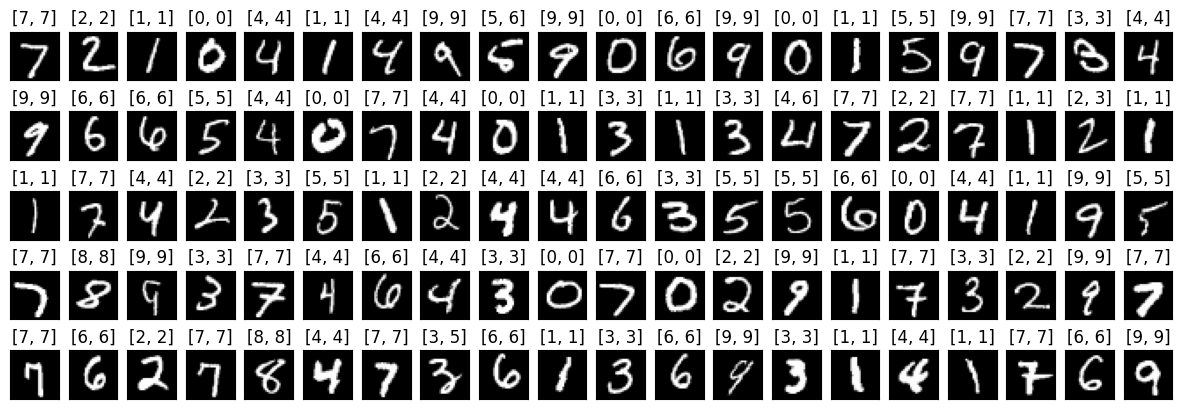

In [ ]:
display_test(x_test[0], y, y_pred2)